<a href="https://colab.research.google.com/github/PeterStoreshaw/PeterStoreshaw.github.io/blob/master/Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 2, What Animal? A deep learning model that can identify 10 different animal species.

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Download images of birds and non-birds

In [2]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.30.0 which is incompatible.


In [3]:
!pip install --upgrade duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [6]:
from fastbook import search_images_ddg 
urls = search_images_ddg('bird photos', max_images=1) 
urls[0]

'http://dreamicus.com/data/bird/bird-05.jpg'

...and then download a URL and take a look at it:

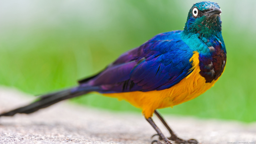

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "cat photos":

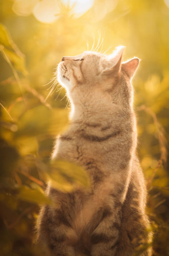

In [8]:
download_url(search_images_ddg('cat photos', max_images=1)[0], 'cat.jpg', show_progress=False) 
Image.open('cat.jpg').to_thumb(256,256) 


Now let's do the same with "gorilla photos":

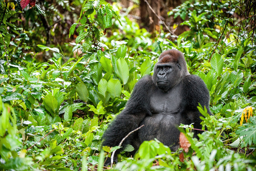

In [9]:
download_url(search_images_ddg('gorilla photos', max_images=1)[0], 'gorilla.jpg', show_progress=False) 
Image.open('gorilla.jpg').to_thumb(256,256) 

Now let's do the same with "insect photos":

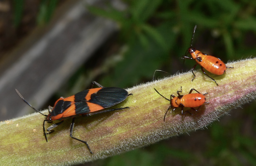

In [10]:
download_url(search_images_ddg('insect photos', max_images=1)[0], 'insect.jpg', show_progress=False) 
Image.open('insect.jpg').to_thumb(256,256) 

Now let's do the same with "fish photos":

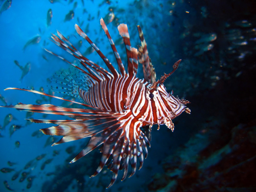

In [11]:
download_url(search_images_ddg('fish photos', max_images=1)[0], 'fish.jpg', show_progress=False) 
Image.open('fish.jpg').to_thumb(256,256) 

Now let's do the same with "kangaroo photos":

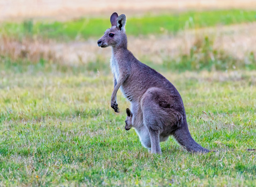

In [12]:
download_url(search_images_ddg('kangaroo photos', max_images=1)[0], 'kangaroo.jpg', show_progress=False) 
Image.open('kangaroo.jpg').to_thumb(256,256) 

Now let's do the same with "koala photos":

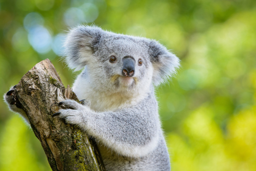

In [13]:
download_url(search_images_ddg('koala photos', max_images=1)[0], 'koala.jpg', show_progress=False) 
Image.open('koala.jpg').to_thumb(256,256) 

Now let's do the same with "elephant photos":

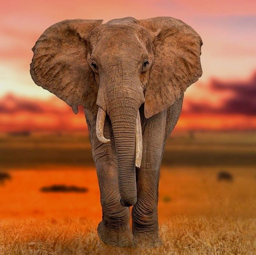

In [14]:
download_url(search_images_ddg('elephant photos', max_images=1)[0], 'elephant.jpg', show_progress=False) 
Image.open('elephant.jpg').to_thumb(256,256) 

Now let's do the same with "lizards photos":

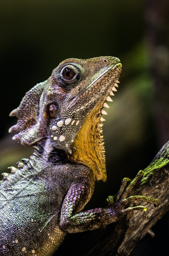

In [15]:
download_url(search_images_ddg('lizard photos', max_images=1)[0], 'lizard.jpg', show_progress=False) 
Image.open('lizard.jpg').to_thumb(256,256) 

Now let's do the same with "frog photos":

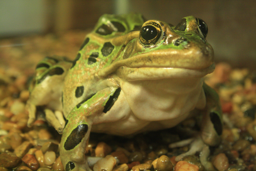

In [16]:
download_url(search_images_ddg('frog photos', max_images=1)[0], 'frog.jpg', show_progress=False) 
Image.open('frog.jpg').to_thumb(256,256) 

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/Q2t.zip'

path = Path('Q2') 

In [17]:
searches = 'cat', 'gorilla', 'insect', 'fish', 'koala', 'kangaroo', 'lizard', 'frog', 'elephant', 'bird' 
path = Path('Q2') 
from time import sleep 

for o in searches: 
    dest = (path/o) 
    dest.mkdir(exist_ok=True, parents=True) 
    download_images(dest, urls=search_images_ddg(f'{o} photo')) 
    sleep(10)  # Pause between searches to avoid over-loading server 
    download_images(dest, urls=search_images_ddg(f'{o} sun photo')) 
    sleep(10) 
    download_images(dest, urls=search_images_ddg(f'{o} shade photo')) 
    sleep(10) 
    resize_images(path/o, max_size=400, dest=path/o) 


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

263

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

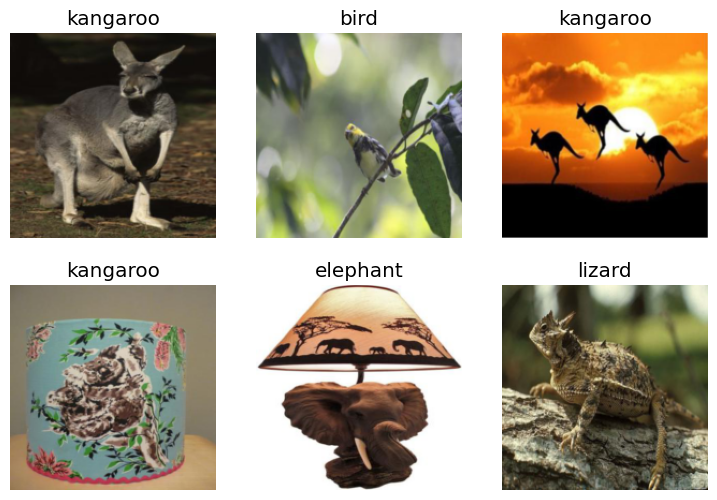

In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [20]:
from google.colab import drive

# mount will create a folder at the left folder section on the page, but it will take a minute or so to see it

drive.mount('/content/drive') 

!zip -r Q2.zip Q2

!cp Q2.zip /content/drive/My\ Drive/ 

Streaming output truncated to the last 5000 lines.
  adding: Q2/kangaroo/8689454b-da81-4c78-bac2-1698a800f583.jpg (deflated 1%)
  adding: Q2/kangaroo/1db8b70e-b0a0-4986-8593-759b21578f0a.jpeg (deflated 1%)
  adding: Q2/kangaroo/864d3b0b-0d7b-41ae-bbde-a68c0b5a9d42.jpg (deflated 2%)
  adding: Q2/kangaroo/59b17d49-6cea-4492-be67-bdabb3402ca2.jpg (deflated 1%)
  adding: Q2/kangaroo/a6bff3b7-843c-4544-ab16-7dfee4c02d78.jpg (deflated 1%)
  adding: Q2/kangaroo/205acef2-5a0a-4051-9480-ee36ddcf0cce.jpg (deflated 1%)
  adding: Q2/kangaroo/4cfca0df-7231-4ff7-a1ef-afa82c5fb160.jpg (deflated 0%)
  adding: Q2/kangaroo/eb482df4-abbb-4580-a09a-1458512544ab.jpg (deflated 1%)
  adding: Q2/kangaroo/a4e21eec-babc-4a3c-988f-d6b42b8592ef.jpg (deflated 0%)
  adding: Q2/kangaroo/314251a6-9492-4e2e-94aa-0a599b548b33.jpg (deflated 1%)
  adding: Q2/kangaroo/6abefcb1-c3b7-4745-9330-1a3a1548142b.jpg (deflated 1%)
  adding: Q2/kangaroo/5d7c3c9d-6d28-44d1-8113-da69dc0fa63d.jpg (deflated 1%)
  adding: Q2/kangaroo/bf

In [21]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.389056,0.581852,0.167582,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.613048,0.491519,0.144689,00:32
1,0.351330,0.500304,0.133700,00:35
2,0.162952,0.467441,0.133700,00:33


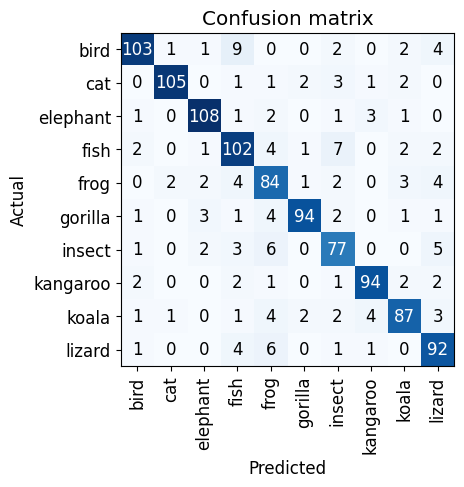

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

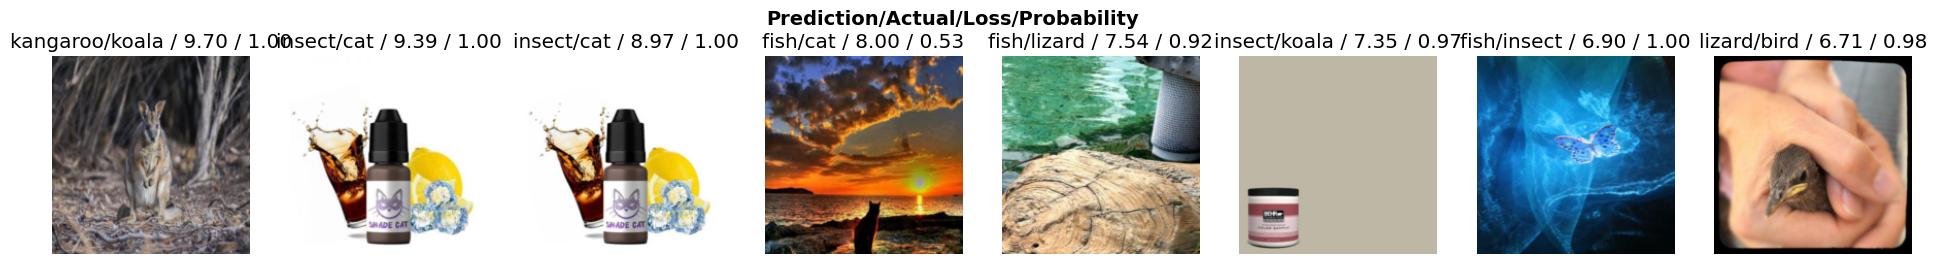

In [32]:
interp.plot_top_losses(8, nrows=1)


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [29]:
is_bird,_,probs = learn.predict(PILImage.create('images.jpg'))
print(f"This is a: {is_bird}.")


This is a: cat.
